In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from copy import deepcopy
from matplotlib import pyplot
from scipy import stats
import logging
import matplotlib
import matplotlib.gridspec as gridspec
import os
import pandas
import string, math, numpy
import sys, os, glob, csv, re

In [4]:
pyplot.style.use('dark_background')
logging.basicConfig(level=logging.INFO)

In [5]:
try:
    from ltrack import config
    import ltrack.lineage.inference_params as inference_params
    import ltrack.lineage.file_parser as file_parser
    from ltrack.lineage.fitness_estimator import *
except ImportError:
    print("Please install the LineageTracking package by running the command line 'pip install .' in the lineage_tracking repository's root directory.")
    raise
except: raise

In [6]:
project_name = os.path.basename(os.getcwd())

In [7]:
population = project_name

In [8]:
timepoints, data, counts = file_parser.get_data(population, config.barcode_data_root_directory)

INFO:root:Processing population LT_5epochs.
INFO:root:Reading files.
INFO:root:Reading files complete.


In [9]:
kappas = file_parser.read_kappas_from_file(config.error_model_directory + population + '-kappas.tsv')

In [10]:
fitness_estimator = FitnessEstimator(counts,kappas)

In [11]:
max_barcode = config.max_barcode[population]    

In [12]:
environment = 'evolution'
barcoding = False

In [13]:
q_values, empirical_null, t_statistic_95_percent_cutoff = determine_q_values(data,fitness_estimator,max_barcode - barcoding,barcoding = barcoding)

/home/grotec/Repositories/lineage-tracking/ltrack/lineage/fitness_estimator.py:60: RuntimeWarning: divide by zero encountered in log
  (np.sqrt(expectations) - np.sqrt(observed[1:]))**2/self.k[begin:end-1]  + 0.75* np.log(observed[1:]) - 0.25* np.log(expectations)
/home/grotec/Repositories/lineage-tracking/ltrack/lineage/fitness_estimator.py:200: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic.append(2*(neutral_llh - min_llh))
/home/grotec/Repositories/lineage-tracking/ltrack/lineage/fitness_estimator.py:202: RuntimeWarning: invalid value encountered in double_scalars
  empirical_null.append(2*(neutral_llh - min_llh))


INFO:root:q value report.


<AxesSubplot:xlabel='Epoch'>

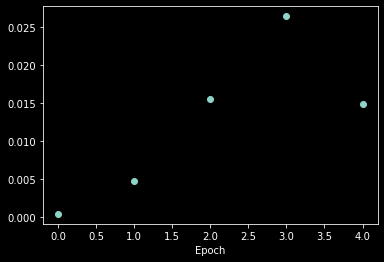

In [14]:
logging.info("q value report.")
pandas.Series(
    q_values,
    index=pandas.Index(
        range(
            len(
                q_values
            )
        ),
        name="Epoch"
    )
).plot(style="o")

In [15]:
logging.info("t statistic 95 percent cutoff: %f", t_statistic_95_percent_cutoff)

INFO:root:t statistic 95 percent cutoff: 4.690783


Text(0, 0.5, 'Null model')

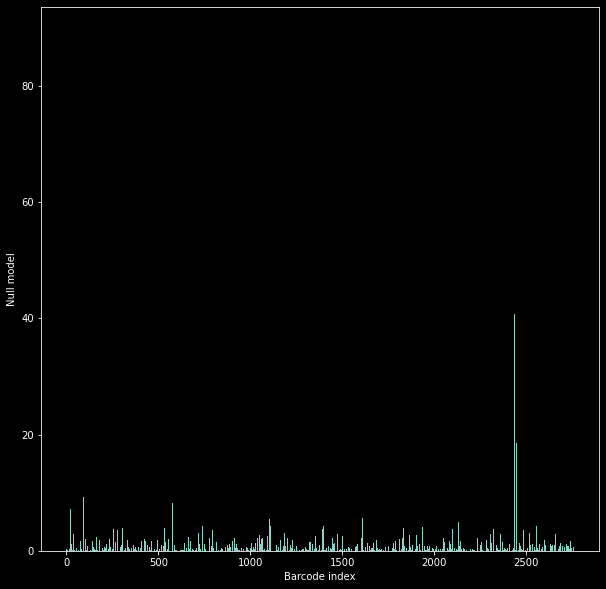

In [16]:
fig, ax = pyplot.subplots(figsize=(10,10))
ax.bar(x=range(len(empirical_null)),height=empirical_null)
ax.set_xlabel("Barcode index")
ax.set_ylabel("Null model")


In [17]:
with open(config.error_model_directory+'%s-q_values_%s.tsv' % (population,environment), 'w') as csvfile:
    out_writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    out_writer.writerow(["%f" %x for x in q_values])
    out_writer.writerow([inference_params.FDR])

with open(config.error_model_directory+'%s-empirical_null_%s.tsv' % (population,environment), 'w') as csvfile:
    out_writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    out_writer.writerow(["%f" %x for x in sorted(empirical_null)])